<a href="https://colab.research.google.com/github/ksun0401/musinsa_recommend/blob/master/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 환경: colab pro
## 의류 이미지 분류와 Grad-CAM을 이용한 영역 모델 해석
> 진행 순서
>> 모델 3개 선정 -> 모델 결정 -> Grad-CAM으로 해석


In [1]:
# 한글 폰트 세팅
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torchvision

from torchvision import transforms
import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import re
from tqdm import tqdm

import gc
import torch

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score

import warnings  
warnings.filterwarnings(action = 'ignore')

print(A.__version__)
!nvidia-smi

1.2.1
Tue Nov 22 06:25:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [5]:
seed = 42

os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [6]:
df = pd.read_csv("/content/drive/MyDrive/data/musinsa_high/musinsa.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53890 entries, 0 to 53889
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    53890 non-null  object
 1   label   53890 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [7]:
df.head()

,path,label
0,/content/drive/MyDrive/data/musinsa_high/musin...,0
1,/content/drive/MyDrive/data/musinsa_high/musin...,0
2,/content/drive/MyDrive/data/musinsa_high/musin...,0
3,/content/drive/MyDrive/data/musinsa_high/musin...,0
4,/content/drive/MyDrive/data/musinsa_high/musin...,0


In [8]:
# 데이터를 0.01배 샘플링하여 빠른 실험 진행

# df_small = df.sample(frac=0.01)
# df_small.info()

In [9]:
# 의류 이름 컬럼 생성을 위해 path에서 이름만 추출

def re_h(x):
    x = re.compile('[a-zA-Z0-9/_.]').sub('', x).strip()
    return x

def cut_label(x):
    x = x[:int(len(x)/2)]
    return x

In [10]:
# 각 label의 개수 확인
# 크게 unbalance하지는 않다.

df['name'] = df['path'].apply(re_h).apply(cut_label)
df['name'].value_counts()

긴팔티               2070
레깅스                2070
후드티                 2070
트레이닝팬츠         2070
플리스                2070
코튼팬츠             2070
코치(나일론)재킷    2070
카라티                 2070
숏패딩               2070
슬랙스               2070
숏팬츠               2070
블루종               2070
블레이저재킷         2070
반팔티               2070
맨투맨               2070
데님팬츠             2070
니트스웨터             2070
기타바지               2070
가디건                2070
후드집업             2070
트러커재킷            2042
기타상의              1945
환절기코트           1803
겨울코트              1721
레더재킷              1674
트레이닝재킷         1313
무스탕                 724
롱패딩                674
바시티재킷             594
Name: name, dtype: int64

In [11]:
# fig = plt.figure(figsize = (15, 15)),
# label_count = df['label'].value_counts()
# label_count
# label_count = df['name'].value_counts()

# sns.barplot(x = df['name'], y = df['name'].value_counts())

In [12]:
# custom_dataset 생성

class Custom_Dataset(Dataset):
    def __init__(self, x, y = None, transforms = None):
        self.x = x
        self.y = y
        self.transforms = transforms
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):

        img = Image.open(self.x[idx]).convert("RGB") # RGB로 변환
        img = np.array(img)
        label = self.y[idx]

        if self.transforms:
            img = self.transforms(image = img)
            img = img['image']
            
        return img, label

In [13]:
train_val_transform = A.Compose([
    A.Resize(256, 256),
    # A.CenterCrop(224, 224, always_apply=True, p=1.0),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(256, 256),
    # A.CenterCrop(224, 224, always_apply=True, p=1.0),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
    ToTensorV2()
])

### train-val-test(8:1:1) 나누기
>train: 43112 <br>
>validation: 5389 <br>
>test: 5389 <br>

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df['path'], df['label'],
                                                  test_size = 0.2, shuffle = True,
                                                  stratify = df['label'], random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
                                                  test_size = 0.5, shuffle = True,
                                                  stratify = y_test, random_state = 42)

x_train = list(x_train)
x_val = list(x_val)
y_train = list(y_train)
y_val = list(y_val)
x_test = list(x_test)
y_test = list(y_test)

In [15]:
# x_train, x_test, y_train, y_test = train_test_split(df_small['path'], df_small['label'],
#                                                   test_size = 0.3, shuffle = True,
#                                                   stratify = df_small['label'], random_state = 42)

# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test,
#                                                   test_size = 0.5, shuffle = True,
#                                                   random_state = 42)

# x_train = list(x_train)
# x_val = list(x_val)
# y_train = list(y_train)
# y_val = list(y_val)
# x_test = list(x_test)
# y_test = list(y_test)

In [16]:
# train: 43112
# val: 5389
# test: 5389

print(f'x_train: {len(x_train)}, y_train: {len(y_train)}\nx_val: {len(x_val)}, y_val: {len(y_val)}\nx_test: {len(x_test)}, y_test: {len(y_test)}')

x_train: 43112, y_train: 43112
x_val: 5389, y_val: 5389
x_test: 5389, y_test: 5389


In [36]:
# DataLoader
# 배치 사이즈: 64
# train만 shuffle 허용

train_dataset = Custom_Dataset(x_train, y_train, transforms = train_val_transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True, num_workers=6)

val_dataset = Custom_Dataset(x_val, y_val, transforms = train_val_transform)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, drop_last = True, num_workers=6)

test_dataset = Custom_Dataset(x_test, y_test, transforms = test_transform)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, drop_last = True, num_workers=0)

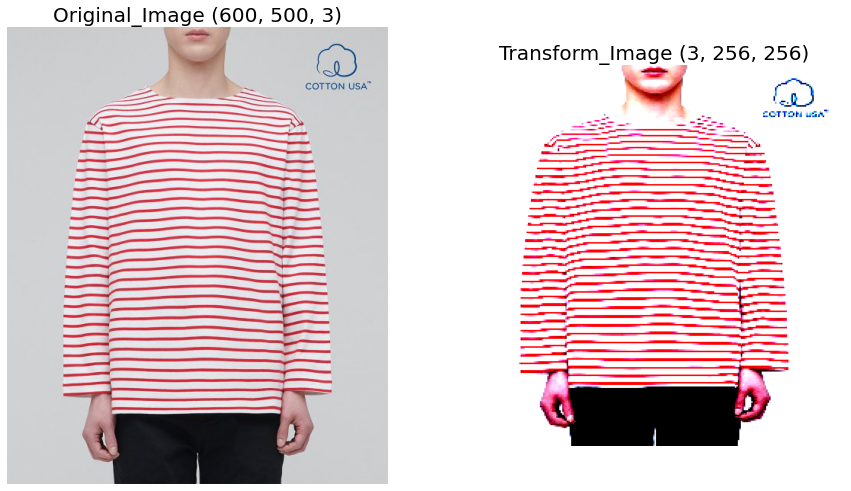

In [24]:
# 원본 이미지와 transform 된 이미지 비교

fig = plt.figure(figsize=(15, 15))
def custom_imshow(img_transform, img):

    img_transform = img_transform.numpy()
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    ax1.set_title('Original_Image (600, 500, 3)', size = 20)
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(np.transpose(img_transform, (1, 2, 0))) 
    ax2.set_title('Transform_Image (3, 256, 256)', size = 20)
    ax2.axis("off")
    plt.show()

img = Image.open(df.path[2022]).convert('RGB')
img = np.array(img)
img_transform = train_val_transform(image = img)
img_transform = img_transform['image']

custom_imshow(img_transform, img)

In [25]:
# EarlyStopping 구현

class EarlyStopping:
    def __init__(self, patience, verbose = False, delta = 0):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.counter = 0
        self.delta = delta
        self.path = '/content/drive/MyDrive/data/save_data/best_model.pth' 

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).\n Saving model ...\n')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss
            

In [31]:
# train셋 학습

def train(model, optimizer, epoch, scheduler, device):
    model = model.to(device)
    early_stopping = EarlyStopping(patience = 3, verbose = True)  # early_stopping 3으로 설정

    train_losses, val_losses = [], [] # train, val loss 리스트로 저장

    for epoch in range(epoch):
        print(f"\n------ {epoch} epoch -------\n")
        model.train()
        train_loss_list = []
        train_loss = 0.0
        
        for img, label in tqdm(iter(train_loader)):  # Dataloader에 저장된 데이터들이 배치 단위로  나온다.
            img, label = img.to(device), label.to(device)

            optimizer.zero_grad()    # 0으로 초기화
            pred = model(img)
            loss = criterion(pred, label)

            loss.backward()     # gradient 계산
            optimizer.step()    # 파라미터 업데이트

            train_loss_list.append(loss.item())

        if scheduler is not None: 
            scheduler.step()    


        model.eval()
        val_loss = 0.0
        val_loss_list = []
        model_preds = []
        true_labels = []

        correct = 0
        
        # validation으로 평가 
        with torch.no_grad():
            for img, label in tqdm(iter(val_loader)):
                img, label = img.to(device), label.to(device)
                
                val_pred = model(img)
                v_loss = criterion(val_pred, label)

                val_loss_list.append(v_loss.item()) 

                model_preds += val_pred.argmax(1).detach().cpu().numpy().tolist()  # 예측값 추출
                true_labels += label.detach().cpu().numpy().tolist() # 실제값 추출
                
                pred = val_pred.argmax(dim=1, keepdim=True)  
                correct += pred.eq(label.view_as(pred)).sum().item() # 맞춘 개수 
        
        # epoch 당 평균 loss 값 
        train_lossed = np.mean(train_loss_list) 
        val_lossed = np.mean(val_loss_list)

        # epoch 당 모든 평균 loss 리스트로 저장
        train_losses.append(train_lossed)
        val_losses.append(val_lossed)

        # 평가 지표 accuracy, precision, f1_score 선정
        val_accuracy = 100 * correct / len(val_loader.dataset)
        precision = precision_score(true_labels, model_preds, average = 'micro')
        f1 = f1_score(true_labels, model_preds, average = "weighted")

        print(f"\nTrain loss: {train_lossed:.4f}")
        print(f"Val Loss: {val_lossed:.4f}")
        print(f"precsion ------> {precision:.5f}")
        print(f"f1_score ------> {f1:.5f}")
        print(f"{correct} / {len(val_loader.dataset)}, Accuracy: {val_accuracy:.3f}%\n")

        # early_stopping을 통해 오버 피팅 방지
        early_stopping(val_lossed, model)
        if early_stopping.early_stop:
            print('Early Stopping')
            break

        model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'))
    return train_losses, val_losses # 저장된 loss history 리턴
   

In [27]:
# test셋 평가

def predict(model, test_loader, device):
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)

    model.to(device)
    model.eval()  # test eval 
    model_pred = []
    true_labels = []
    correct = 0
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.to(device), label.to(device)
            
            test_pred = model(img)

            model_pred += test_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

            pred = test_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
        
    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")

    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")

In [28]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = torchvision.models.resnet50(pretrained = True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 29)
    
    def forward(self, x):
        return self.model(x)

class MobilenetV2(nn.Module):
    def __init__(self):
        super(MobilenetV2, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        self.drop = nn.Dropout(p = 0.3)
        self.model.classifier[1] = nn.Linear(1280, 29)

    def forward(self, x):
        x = self.drop(x)
        return self.model(x)


class Efficientnet(nn.Module):
    def __init__(self):
        super(Efficientnet, self).__init__()
        self.model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
        self.drop = nn.Dropout(p = 0.3)
        self.model.classifier.fc = nn.Linear(1280, 29)
    
    def forward(self, x):
        x = self.drop(x)
        return self.model(x)

In [44]:
# 메모리 캐시 정리

gc.collect()
torch.cuda.empty_cache()

### resnet, mobilenet, efficientnet 3개의 모델로 테스트
> loss: CrossEntropy <br>
> Optimizer: Adam <br>
> learning rate: 0.001

>> best 정확도, 1 epoch 당 시간  
>> resnet: 73%, 9분 <br>
>> mobilenet: 60%, 4분 <br>
>> efficietnet: 51%, 4분 51초  <br>


In [39]:
criterion = nn.CrossEntropyLoss()

resnet = ResNet50() 
mobilenet = MobilenetV2() 
efficientnet = Efficientnet() 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [40]:
resnet_optimizer = optim.Adam(params = resnet.parameters(), lr = 0.001)
resnet_scheduler = optim.lr_scheduler.LambdaLR(resnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                        last_epoch = -1, verbose = False)

train_loss, val_loss = train(resnet, resnet_optimizer, 10, resnet_scheduler, device)


------ 0 epoch -------



100%|██████████| 84/84 [07:45<00:00,  5.54s/it]



Train loss: 1.4814
Val Loss: 1.7158
precsion ------> 0.49721
f1_score ------> 0.48205
2673 / 5389, Accuracy: 49.601%

Validation loss decreased (inf --> 1.715783).
 Saving model ...


------ 1 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.64it/s]



Train loss: 1.0430
Val Loss: 1.4855
precsion ------> 0.54241
f1_score ------> 0.53973
2916 / 5389, Accuracy: 54.110%

Validation loss decreased (1.715783 --> 1.485480).
 Saving model ...


------ 2 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.61it/s]



Train loss: 0.8706
Val Loss: 1.1913
precsion ------> 0.63281
f1_score ------> 0.63545
3402 / 5389, Accuracy: 63.129%

Validation loss decreased (1.485480 --> 1.191316).
 Saving model ...


------ 3 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.61it/s]



Train loss: 0.7281
Val Loss: 1.0137
precsion ------> 0.67950
f1_score ------> 0.68096
3653 / 5389, Accuracy: 67.786%

Validation loss decreased (1.191316 --> 1.013670).
 Saving model ...


------ 4 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.60it/s]



Train loss: 0.6076
Val Loss: 0.9956
precsion ------> 0.69810
f1_score ------> 0.69943
3753 / 5389, Accuracy: 69.642%

Validation loss decreased (1.013670 --> 0.995556).
 Saving model ...


------ 5 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.63it/s]



Train loss: 0.4808
Val Loss: 0.8952
precsion ------> 0.73177
f1_score ------> 0.73353
3934 / 5389, Accuracy: 73.001%

Validation loss decreased (0.995556 --> 0.895220).
 Saving model ...


------ 6 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.55it/s]



Train loss: 0.3659
Val Loss: 1.1897
precsion ------> 0.67894
f1_score ------> 0.68146
3650 / 5389, Accuracy: 67.731%

EarlyStopping counter: 1 out of 3

------ 7 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.51it/s]



Train loss: 0.3331
Val Loss: 1.1966
precsion ------> 0.68248
f1_score ------> 0.68763
3669 / 5389, Accuracy: 68.083%

EarlyStopping counter: 2 out of 3

------ 8 epoch -------



100%|██████████| 84/84 [00:23<00:00,  3.56it/s]


Train loss: 0.3165
Val Loss: 1.3714
precsion ------> 0.63765
f1_score ------> 0.63561
3428 / 5389, Accuracy: 63.611%

EarlyStopping counter: 3 out of 3
Early Stopping


Text(0.5, 1.0, 'train vs valid')

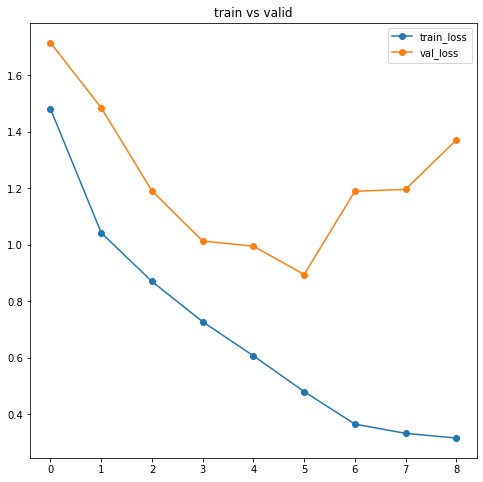

In [41]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [43]:
predict(resnet, test_loader, device)

100%|██████████| 84/84 [45:39<00:00, 32.61s/it]


precsion ------> 0.72805
f1_score ------> 0.73012
3914 / 5389, Accuracy: 72.629%



In [45]:
mobilenet_optimizer = optim.Adam(params = mobilenet.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.LambdaLR(mobilenet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                         last_epoch = -1, verbose = False)

train_loss, val_loss = train(mobilenet, mobilenet_optimizer, 20, scheduler, device)


------ 0 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.30it/s]



Train loss: 1.7254
Val Loss: 1.6053
precsion ------> 0.49888
f1_score ------> 0.48938
2682 / 5389, Accuracy: 49.768%

Validation loss decreased (inf --> 1.605335).
 Saving model ...


------ 1 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.24it/s]



Train loss: 1.3262
Val Loss: 1.4061
precsion ------> 0.55208
f1_score ------> 0.54483
2968 / 5389, Accuracy: 55.075%

Validation loss decreased (1.605335 --> 1.406134).
 Saving model ...


------ 2 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.26it/s]



Train loss: 1.1676
Val Loss: 1.2535
precsion ------> 0.60863
f1_score ------> 0.60007
3272 / 5389, Accuracy: 60.716%

Validation loss decreased (1.406134 --> 1.253453).
 Saving model ...


------ 3 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.27it/s]



Train loss: 1.0595
Val Loss: 1.3877
precsion ------> 0.57403
f1_score ------> 0.57310
3086 / 5389, Accuracy: 57.265%

EarlyStopping counter: 1 out of 3

------ 4 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.22it/s]



Train loss: 1.0427
Val Loss: 1.4873
precsion ------> 0.55060
f1_score ------> 0.54757
2960 / 5389, Accuracy: 54.927%

EarlyStopping counter: 2 out of 3

------ 5 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.25it/s]


Train loss: 1.0334
Val Loss: 1.2565
precsion ------> 0.61124
f1_score ------> 0.60422
3286 / 5389, Accuracy: 60.976%

EarlyStopping counter: 3 out of 3
Early Stopping


Text(0.5, 1.0, 'train vs valid')

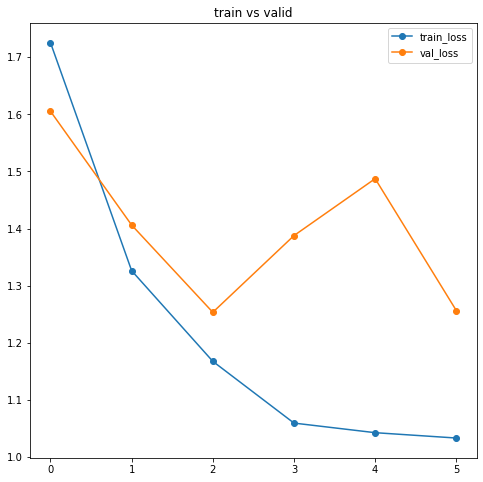

In [46]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [47]:
predict(mobilenet, test_loader, device)

100%|██████████| 84/84 [00:47<00:00,  1.78it/s]


precsion ------> 0.60472
f1_score ------> 0.60052
3251 / 5389, Accuracy: 60.327%



In [49]:
efficientnet_optimizer = optim.Adam(params = efficientnet.parameters(), lr = 0.001)
efficientnet_scheduler = optim.lr_scheduler.LambdaLR(efficientnet_optimizer, lr_lambda = lambda epoch:0.95**epoch,
                                                     last_epoch = -1, verbose = False)
    
train_loss, val_loss = train(efficientnet, efficientnet_optimizer, 20, efficientnet_scheduler, device)


------ 0 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.21it/s]



Train loss: 0.8693
Val Loss: 2.1240
precsion ------> 0.41276
f1_score ------> 0.40898
2219 / 5389, Accuracy: 41.176%

Validation loss decreased (inf --> 2.124046).
 Saving model ...


------ 1 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.21it/s]



Train loss: 0.7062
Val Loss: 1.7880
precsion ------> 0.52102
f1_score ------> 0.52096
2801 / 5389, Accuracy: 51.976%

Validation loss decreased (2.124046 --> 1.787970).
 Saving model ...


------ 2 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.30it/s]



Train loss: 0.5580
Val Loss: 2.0127
precsion ------> 0.51060
f1_score ------> 0.52679
2745 / 5389, Accuracy: 50.937%

EarlyStopping counter: 1 out of 3

------ 3 epoch -------



100%|██████████| 84/84 [00:19<00:00,  4.27it/s]



Train loss: 0.5383
Val Loss: 2.6526
precsion ------> 0.34542
f1_score ------> 0.33346
1857 / 5389, Accuracy: 34.459%

EarlyStopping counter: 2 out of 3

------ 4 epoch -------



100%|██████████| 84/84 [00:20<00:00,  4.06it/s]


Train loss: 0.5195
Val Loss: 2.0681
precsion ------> 0.51693
f1_score ------> 0.53245
2779 / 5389, Accuracy: 51.568%

EarlyStopping counter: 3 out of 3
Early Stopping


Text(0.5, 1.0, 'train vs valid')

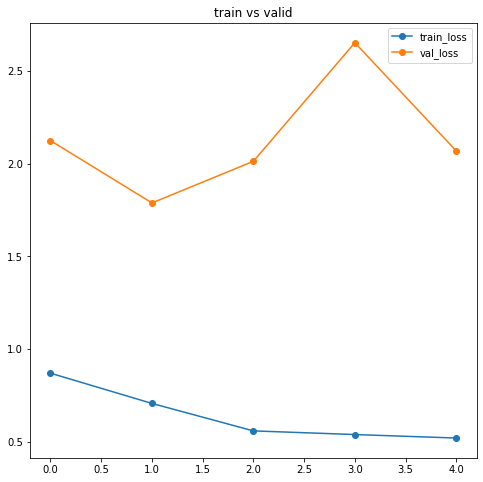

In [50]:
# train , val loss 시각화

fig = plt.figure(figsize = (8, 8))
plt.plot(train_loss, marker = 'o', label='train_loss')
plt.plot(val_loss, marker = 'o', label='val_loss')
plt.legend()
plt.title('train vs valid')

In [51]:
predict(efficientnet, test_loader, device)

100%|██████████| 84/84 [00:45<00:00,  1.84it/s]


precsion ------> 0.51488
f1_score ------> 0.51456
2768 / 5389, Accuracy: 51.364%



In [52]:
# 마지막 convolution layer
# 분류 부분 파라미터 추출

final_conv = resnet.model.layer4[-1]
print(final_conv)
fc_params = list(resnet.model.fc.parameters())

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


## 성능이 가장 좋았던 resnet을 통해 Grad-CAM 시각화 
> 현재 히트맵을 통해 시각화를 하는 것은 가능합니다

> 목표하고자 하는 것
>> 정답과 오답을 나누어 5개 씩 히트맵 확인

In [57]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()


# def getCAM(feature_conv, weight_fc, class_idx, cur_images):
#     _, nc, h, w = feature_conv.shape

#     cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
#     # print(cam)
#     fig = plt.figure(figsize=(30, 30))
#     # cam = cam[0, :].reshape(h, w)
#     # cam = cam - np.min(cam)
#     # cam_img = cam / np.max(cam)
#     # print(cam_img.shape)
#     for i in range(10):
#         cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
#         cam = cam[i, :].reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         # cam_img = cam_img.astype(np.uint16)
        
#         ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
#         plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
#         plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
#         ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
#         # return cam_img



def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=10, img_size=224, device='cpu', original=False):
    for param in model.parameters():
        param.requires_grad = False
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/resnet_best_model.pth'), strict = False)
    model.to(device)
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)
    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy())
    # original images
    # heatmap images

    fig = plt.figure(figsize=(30, 30))
    # fig = plt.figure(figsize=(10, 10))
    for i, (img, target) in enumerate(tqdm(test_loader)):
        output = model(img.to(device))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

        # getCAM(activated_features.features, weight, pred_idx, cur_images)

        _, nc, h, w = activated_features.features.shape # chanel, height, width 언패킹

        # cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
        # print(cam)
        
        # cam = cam[0, :].reshape(h, w)
        # cam = cam - np.min(cam)
        # cam_img = cam / np.max(cam)
        # print(cam_img.shape)
    for i in range(5):
        cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
        cam = cam[i, :].reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        # cam_img = cam_img.astype(np.uint16)
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        # ax.set_title('Label:%s, Predict:%s'% (df['name'].unique()[target[i]], df['name'].unique()[pred_idx[i]]), fontsize=14)
        ax.set_title('Label:%d, Predict:%d'% (target[i], pred_idx[i]), fontsize=14)
        # heatmap = getCAM(activated_features.features, weight, pred_idx)
        # ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])

        # plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
        # plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        # ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
        if i == row*col-1:
            break
    plt.show()

100%|██████████| 84/84 [10:39<00:00,  7.62s/it]


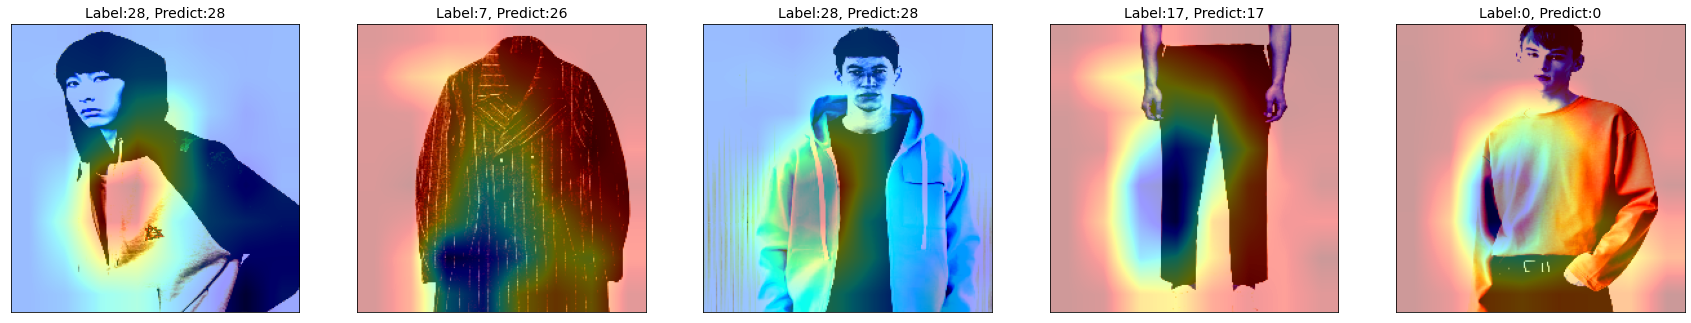

In [58]:
plotGradCAM(resnet, final_conv, fc_params, test_loader)

In [ ]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()



def getCAM(feature_conv, weight_fc, class_idx, cur_images):
    _, nc, h, w = feature_conv.shape

    cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
    # print(cam)
    fig = plt.figure(figsize=(30, 30))
    # cam = cam[0, :].reshape(h, w)
    # cam = cam - np.min(cam)
    # cam_img = cam / np.max(cam)
    # print(cam_img.shape)
    for i in range(10):
        cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
        cam = cam[i, :].reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        # cam_img = cam_img.astype(np.uint16)
        
        ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
        plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
        # return cam_img



def plotGradCAM(model, final_conv, fc_params, train_loader, 
                row=1, col=10, img_size=224, device='cpu', original=False):
    for param in model.parameters():
        param.requires_grad = False
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/data/save_data/best_model.pth'), strict = False)
    model.to(device)

    model_pred = []
    true_labels = []
    correct = 0
    model.eval()
    # save activated_features from conv
    activated_features = SaveFeatures(final_conv)
    # save weight from fc
    weight = np.squeeze(fc_params[0].cpu().data.numpy())
    # original images
    # heatmap images

    # fig = plt.figure(figsize=(10, 10))
    for img, target in tqdm(iter(test_loader)):
        output = model(img.to(device))
        pred_idx = output.to('cpu').numpy().argmax(1)
        cur_images = img.cpu().numpy().transpose((0, 2, 3, 1))

        # getCAM(activated_features.features, weight, pred_idx, cur_images)

        _, nc, h, w = activated_features.features.shape # chanel, height, width 언패킹
        fig = plt.figure(figsize=(30, 30))

        for i in range(5):
            cam = weight[pred_idx].dot(activated_features.features[0, :, :, ].reshape((nc, h*w)))
            cam = cam[i, :].reshape(h, w)
            cam = cam - np.min(cam)
            cam_img = cam / np.max(cam)

            ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
            plt.imshow(cv2.cvtColor(cur_images[i], cv2.COLOR_BGR2RGB))
            plt.imshow(cv2.resize(cam_img, (224, 224), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
            # ax.set_title('Label:%s, Predict:%s'% (df['name'].unique()[target[i]], df['name'].unique()[pred_idx[i]]), fontsize=14)
            ax.set_title('Label:%d, Predict:%d'% (target[i], pred_idx[i]), fontsize=14)
        # heatmap = getCAM(activated_features.features, weight, pred_idx)
        # ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])

        # plt.imshow(cv2.cvtColor(cur_images[0], cv2.COLOR_BGR2RGB))
        # plt.imshow(cv2.resize(heatmap, (img_size, img_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet')
        # ax.set_title('Label:%d, Predict:%d' % (target, pred_idx), fontsize=14)
            if i == row*col-1:
                break

        model_pred += output.argmax(1).detach().cpu().numpy().tolist()
        true_labels += target.detach().cpu().numpy().tolist()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        

    test_accuracy = 100 * correct / len(test_loader.dataset)
    precision = precision_score(true_labels, model_pred, average = 'micro')
    f1 = f1_score(true_labels, model_pred, average = "weighted")

    print(f"\nprecsion ------> {precision:.5f}")
    print(f"f1_score ------> {f1:.5f}")
    print(f"{correct} / {len(test_loader.dataset)}, Accuracy: {test_accuracy:.3f}%\n")


    plt.show()

In [ ]:
# class SaveFeatures():
#     features = None
#     def __init__(self, m):
#         self.hook = m.register_forward_hook(self.hook_fn)

#     def hook_fn(self, module, input, output):
#         self.features = ((output.cpu()).data).numpy()

#     def remove(self):
#         self.hook.remove()

# def getCAM(feature_conv, weight_fc, class_idx):
#     _, nc, h, w = feature_conv.shape

#     cam = weight_fc[class_idx].dot(feature_conv[0, :, :, ].reshape((nc, h*w)))
    
#     cam = cam[0, :].reshape(h, w)

#     print(cam)
#     cam = cam - np.min(cam)
#     cam_img = cam / np.max(cam)
#     return cam_img

# def plotGradCAM(model, final_conv, fc_params, test_loader, row = 1, col = 8,
#                 img_size = 224, device = device, original = False):
#     model.to(device)
#     model.eval()

#     model_pred = []
#     true_labels = []

#     activated_features = SaveFeatures(final_conv)
#     weight = np.squeeze(fc_params[0].cpu().data.numpy())


#     for i, (img, label) in enumerate(test_loader):
#         img, label = img.to(device), label.to(device)

#         test_pred = model(img)
#         pred_idx = test_pred.detach().cpu().numpy().argmax(1)
#         cur_images = img.detach().cpu().numpy()
#         cur_images = img.detach().cpu().numpy().transpose((0, 2, 3, 1))
#         heatmap = getCAM(activated_features.features, weight, pred_idx)
#         print(heatmap)
            